# Phineus

This demo shows the power of VENumML to do time series predict - on encrypted data! Here we will show how to model trends and seasonality in time series data using fourier transforms and linear regression. The model performs similarly to the popular timeseries forecasting model, Prophet.

Phineus, in Greek mythology, is known as a blind prophet and king of Salmydessus in Thrace. 

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import venumpy
import numpy as np
import pandas as pd
from venumMLlib.venum_tools import encrypt_array, decrypt_array
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from venumMLlib.time_series.Phineus.phineus_timeseries import phineus_predict, reconstruct_signal, extend_date_column

## Instantiate encrypted context 
As usual, let's set up our context.

In [3]:
ctx = venumpy.SecretContext.new_with_security(128)

## Generate Time Series Data 
Now, let's generate some time series data that has an authentic feel to it. There should be a trend, some seasonality, noise, maybe even some brownian motion! 

In [4]:
def generate_synthetic_data(start_date='2019-01-01', end_date='2022-01-01', freq='D',num_spikes=0, spike_scale=3, trend_slope=5, seasonal_period=365, noise_scale=0.5, random_seed=42, add_irregular_seasonal=True, add_random_walk=True):
    np.random.seed(random_seed)
    dates = pd.date_range(start_date, end_date, freq=freq)

    # Adding an upward trend: increment increases linearly over time
    trend = np.linspace(0, trend_slope, len(dates))
    
    # Base seasonal data
    seasonal_data = np.sin(dates.dayofyear / seasonal_period * 2 * np.pi)
    
    if add_irregular_seasonal:
        # Add more complexity to seasonal data
        seasonal_data += 0.5 * np.sin(dates.dayofyear / (seasonal_period / 2) * 2 * np.pi)
    
    # Add random noise
    noise = np.random.normal(scale=noise_scale, size=len(dates))
    
    # Combine components
    base_data = seasonal_data + noise + trend
    
    if add_random_walk:
        # Introduce a random walk component
        random_walk = np.cumsum(np.random.normal(scale=0.2, size=len(dates)))
        base_data += random_walk
    
    # Convert base_data to a numpy array to handle mutable operations
    base_data = np.array(base_data)
    
    # Introduce random spikes
    if num_spikes > 0:
        spike_indices = np.random.choice(len(dates), num_spikes, replace=False)
        spike_magnitudes = np.random.normal(scale=spike_scale, size=num_spikes)
        for i, index in enumerate(spike_indices):
            base_data[index] += spike_magnitudes[i]
    
    data = pd.DataFrame({'ds': dates, 'y': base_data})
    
    return data


In [5]:
data = generate_synthetic_data()

## Encrypt sensitive data.
Let's go ahead and encrypt the "y" column. For ease of understanding, we won't be encrypting the dates. 

In [6]:
data['y'] = data['y'].apply(lambda x: ctx.encrypt(x))

As you can see, the y column in the dataframe is now encryped

In [7]:
data

,ds,y
0,2019-01-01,<venumpy.Ciphertext object at 0x15ee22610>
1,2019-01-02,<venumpy.Ciphertext object at 0x15ee22700>
2,2019-01-03,<venumpy.Ciphertext object at 0x15ee226a0>
3,2019-01-04,<venumpy.Ciphertext object at 0x15ee225e0>
4,2019-01-05,<venumpy.Ciphertext object at 0x15ee22550>
...,...,...
1092,2021-12-28,<venumpy.Ciphertext object at 0x15ee773a0>
1093,2021-12-29,<venumpy.Ciphertext object at 0x15ee77400>
1094,2021-12-30,<venumpy.Ciphertext object at 0x15ee77460>
1095,2021-12-31,<venumpy.Ciphertext object at 0x15ee774c0>


## Predict future trends
Now we are going to use a combination of Fourier transformers, linear regression and gradient descent to predict future trends on this time series data. This will return the complex FFT output, the trend line, the time dimension and relevant frequencies. 

In [8]:
forecast_periods = 90

In [9]:
fft_values, frequencies, total_t, trend_predictions = phineus_predict(ctx, data, forecast_periods = forecast_periods ,smoothing = True, window_size=7)

## Decrypt FFT
Now, let's decrypt the FFT output and the trend line. The FFT output is a tuple of encrypted real and imaginary values. After decrypting, we will convert these values to complex numbers for ease of use. The trend line is linear fit of the data trend. 

In [10]:
def decrypt_fft(fft_values):
    return np.asarray([np.complex128(complex(re.decrypt(),im.decrypt())) for re,im in fft_values])

In [11]:
trend_predictions_decrypted = decrypt_array(trend_predictions)

In [12]:
fft_output = decrypt_fft(fft_values)

Now that we have decrypted the FFT output, we can calculate the amplitudes of the various frequency components, as well as their phase

In [13]:
amplitudes = np.abs(fft_output)

In [14]:
phases = np.angle(fft_output)

Using these values we can stitch them together into a seasonal trend. Play around with selecting how many of the frequencies you wish to keep! 

In [15]:
seasonal_trend = reconstruct_signal(amplitudes, phases, frequencies, total_t, number_of_frequencies= 10)

In [16]:
phineus_curve = trend_predictions_decrypted + seasonal_trend

## Forecast Dataframe
Now let's create a new dataframe with an extended timeline that holds these predicted values. 

In [17]:
future_forecast = extend_date_column(data, 'ds', extension_count = forecast_periods, frequency= 'D')

In [18]:
future_forecast['yhat'] = phineus_curve

## Decrypt original data
Let's see how our model performed by decrypted the original data.

In [19]:
data["y"] = data.y.apply(lambda x: ctx.decrypt(x))

## Compare to Prophet
Let's compare out model against Prophet, a well known time series prediction tool for plaintext data.

In [20]:
m= Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(data)
future = m.make_future_dataframe(periods=forecast_periods)
forecast_prophet = m.predict(future)

15:31:43 - cmdstanpy - INFO - Chain [1] start processing
15:31:43 - cmdstanpy - INFO - Chain [1] done processing


## Calculate error
To help us quantify the efficacy of these models, we can calculate the RMSE.

In [21]:
# Calculate RMSE for the historical fit
rmse_prophet = mean_squared_error(data['y'], forecast_prophet.loc[:len(data)-1, 'yhat'], squared=False)
rmse_custom = mean_squared_error(data['y'], future_forecast['yhat'][:len(data)], squared=False)

## Plot curves 
Now let's plot the results. Not bad for a blind prophet! 

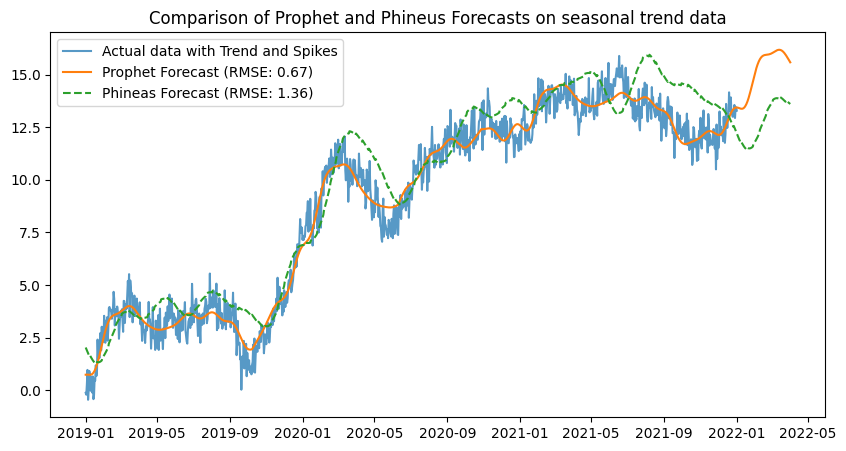

In [22]:
plt.figure(figsize=(10, 5))
plt.plot(data['ds'], data['y'], label='Actual data with Trend and Spikes', alpha=0.75)
plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label=f'Prophet Forecast (RMSE: {rmse_prophet:.2f})')
# plt.plot(forecast_prophet['ds'], forecast_prophet['yhat'], label=f'Prophet Forecast (RMSE: ')

plt.plot(future_forecast['ds'], future_forecast['yhat'],label=f'Phineas Forecast (RMSE: {rmse_custom:.2f})', linestyle='--')
plt.legend()
plt.title('Comparison of Prophet and Phineus Forecasts on seasonal trend data')
plt.show()